In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print("using devie: %s" % device)

using devie: cpu


In [2]:
from torchvision import transforms

tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
from segdataset import SegDataset

DS_ROOT = "/Users/liangkun/dataset/prepped"
train_ds = SegDataset(DS_ROOT, "train", tfms)
test_ds = SegDataset(DS_ROOT, "test", tfms)

print(f"train ds: {len(train_ds)}, test ds: {len(test_ds)}")

train ds: 367, test ds: 101


/Users/liangkun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


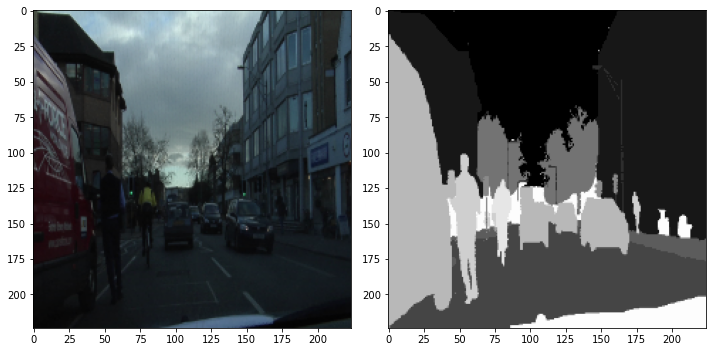

In [6]:
def imshow(ds, row, col, figsize=(6, 6)):
    fig, axes = plt.subplots(row, col*2, figsize=figsize)
    axes = list(axes.flat)
    for i in range(row * col):
        img, mask = ds[i]
        axes[i*2].imshow(img)
        axes[i*2 + 1].imshow(mask * (255 // 11))
    fig.tight_layout()
    fig.show()

imshow(train_ds, 1, 1, figsize=(10, 10))

In [5]:
# trainning preparation
from unet import Unet

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=train_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

model = Unet()
model = model.to(device)
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, dim=1)[1] == targtes).float().mean()
    return ce_loss, acc

optimizer = optim.Adam(model.parameters(), lr=1e-3)
        
def train_batch(model, xs, ys, lossfn, optimizer):
    model.train()
    preds = model(xs)
    loss, acc = lossfn(preds, ys)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), acc.item()

@torch.no_grad()
def test_batch(model, xs, ys, lossfn):
    model.eval()
    preds = model(xs)
    loss, acc = lossfn(preds, ys)
    return loss.item(), acc.item()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /Users/liangkun/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
  0%|          | 408k/528M [01:05<24:05:31, 6.38kB/s] 


KeyboardInterrupt: 

In [ ]:
# training
import time 
import numpy as np

for epoch in range(3):
    start = time.time()

    losses = []
    acces = []
    for xs, ys in train_dl:
        xs = xs.to(device)
        ys = ys.to(device)
        loss, acc = train_batch(model, xs, ys, UnetLoss, optimizer)
        losses.append(loss)
        acces.append(acc)
    epoch_train_loss = np.mean(losses)
    epoch_train_acc = np.mean(acces)

    losses = []
    acces = []
    for xs, ys in test_dl:
        xs = xs.to(device)
        ys = ys.to(device)
        loss, acc = test_batch(model, xs, ys, UnetLoss)
        losses.append(loss)
        acces.append(acc)
    epoch_test_loss = np.mean(losses)
    epoch_test_acc = np.mean(acces)

    consume = time.time() - start
    print(f"epoch {epoch}, consume {consume:.0f}s: \
        train loss={epoch_train_loss:.2f}, test loss = {epoch_test_loss:.2f}, \
        train acc = {epoch_train_acc:.2f}, test acc = {epoch_test_acc:.2f}")
    torch.save(model, f"unet_{epoch}.pt")